<a href="https://colab.research.google.com/github/Derun-Chai/Assignment1/blob/https%2Fgithub.com%2FAlocinYerv%2FTulip.git/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="list-group" id="list-tab" role="tablist">
<h1 class="list-group-item list-group-item-action active" data-toggle="list" style='background:black; border:0; color:#dfbf9f' role="tab" aria-controls="home"><center>CIFAR-10 - Object Recognition in Images usnig ResNet9</center></h1>

<a id="1"></a>
<div class="list-group" id="list-tab" role="tablist">
<h1 class="list-group-item list-group-item-action active" data-toggle="list" style='background:black; border:0; color:#dfbf9f' role="tab" aria-controls="home"><center>About Dataset</center></h1>

`CIFAR-10  is an established computer-vision dataset used for object recognition. It is a subset of the 80
 million tiny images dataset and consists of 60,000 32x32 color images containing one of 10 object classes,
 with 6000 images per class. It was collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton.`



![cifar10](https://miro.medium.com/max/709/1*LyV7_xga4jUHdx4_jHk1PQ.png)

<div class="list-group" id="list-tab" role="tablist">
<h1 class="list-group-item list-group-item-action active" data-toggle="list" style='background:black; border:0; color:#dfbf9f' role="tab" aria-controls="home"><center>Table of Contents</center></h1>

- [Import Libaries](#1)
- [Exploring the Data](#2)     
- [Data Transformation (Data Normalisation and Data Augmentation)](#3)
- [GPU Helper Functions](#4)
- [ResNet](#5)
- [Training the model](#6)
- [Conclusion](#7)

<a id="1"></a>
# Import Libaries

In [2]:
# importing libraries
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import CIFAR10
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor,ToPILImage
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tt
import numpy as np

In [3]:
from numba import cuda
cuda.select_device(0)
cuda.close()
cuda.select_device(0)

<weakproxy at 0x7bbac1fba840 to Device at 0x7bbac1faa620>

<a id="2"></a>
# Exploring the Data

In [4]:
# Load cifar-10
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xzvf cifar-10-python.tar.gz


--2023-10-24 10:29:10--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz.5’

cifar-10-python.tar 100%[===================>] 162.60M  14.8MB/s    in 13s     

2023-10-24 10:29:23 (12.9 MB/s) - ‘cifar-10-python.tar.gz.5’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


The dataset is extracted to the directory `input/cifar10`. It contains 2 folders `train` and `test`, containing the training set (50000 images) and test set (10000 images) respectively. Each of them contains 10 folders, one for each class of images. Let's verify this using `os.listdir`.

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms

# Transform to convert images to PyTorch tensors
transform = transforms.Compose([transforms.ToTensor()])

# Load the training data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Get the class names
classes = trainset.classes

# Find the index of the "cat" class
cat_idx = classes.index('cat')

# Count the number of "cat" examples
num_cats = sum([label == cat_idx for _, label in trainset])

print('No of training examples for cats:', num_cats)


Files already downloaded and verified
No of training examples for cats: 5000


<a id="3"></a>
# Data Transformation (Data Normalisation and Data Augmentation)

In [6]:
stats= ((0.4914,0.4822,0.4465),(0.2023,0.1994,0.2010)) #mean and std
train_tfm= tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), # transormation of data together
                       tt.RandomHorizontalFlip(),
                       tt.ToTensor(),tt.Normalize(*stats,inplace=True)])
valid_tfm = tt.Compose([tt.ToTensor(),tt.Normalize(*stats)])

In [7]:
# Load the datasets
train_ds = CIFAR10(root='./data', train=True, transform=train_tfm, download=True)
valid_ds = CIFAR10(root='./data', train=False, transform=valid_tfm, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
train_ds

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )

In [9]:
img, label= train_ds[0]
print(img.shape,label)
img

torch.Size([3, 32, 32]) 6


tensor([[[-0.1416, -0.1029, -0.3161,  ..., -0.2967, -0.8201, -1.4792],
         [-0.0447, -0.1223, -0.0641,  ..., -0.7232, -1.4404, -2.0801],
         [ 0.6338,  0.5174,  0.4399,  ..., -0.5293, -1.1109, -1.4598],
         ...,
         [ 1.5642, -0.0253, -1.0527,  ...,  0.1104,  0.4981,  0.8276],
         [ 0.9245, -1.3435, -1.7894,  ...,  0.5950,  0.9051,  1.1765],
         [ 0.6725, -1.3435, -1.4017,  ...,  1.1184,  1.2735,  1.4091]],

        [[-0.7662, -0.7662, -0.9826,  ..., -1.0022, -1.4349, -1.8873],
         [-0.6876, -0.7859, -0.7072,  ..., -1.4152, -1.8873, -2.2609],
         [ 0.1778,  0.0401,  0.0204,  ..., -0.9826, -1.3562, -1.4742],
         ...,
         [ 0.9841, -0.5892, -1.4742,  ..., -0.6876, -0.2352, -0.0189],
         [ 0.4138, -1.8479, -2.0446,  ..., -0.0582,  0.3154,  0.4924],
         [ 0.1974, -1.8086, -1.7496,  ...,  0.4531,  0.6694,  0.7481]],

        [[-1.2459, -1.2459, -1.4020,  ..., -1.4215, -1.7727, -2.0653],
         [-1.1483, -1.2459, -1.1093,  ..., -1

In [10]:
def show_image(img, label):
    print('Label: ', train_ds.classes[label], "(" + str(label) + ")")

    # Normalize the image tensor values to [0, 1]
    img = img.clamp(0, 1)

    plt.imshow(img.permute(1, 2, 0))
    plt.show()

Label:  ship (8)


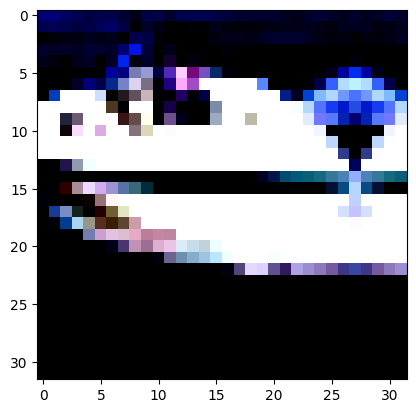

In [11]:
show_image(train_ds[222][0],train_ds[222][1])

Label:  horse (7)


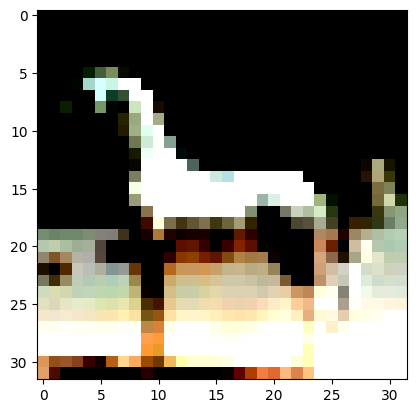

In [12]:
show_image(*train_ds[1543])

Label:  airplane (0)


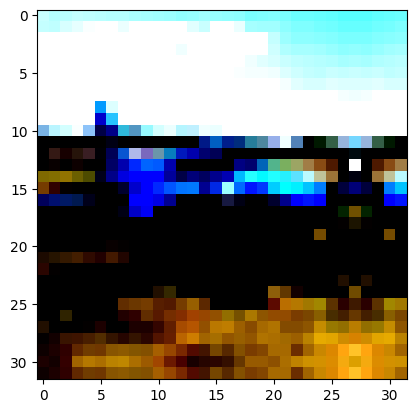

In [13]:
show_image(*train_ds[453])

We'll use a relatively large batch size of 400 to utlize a larger portion of the GPU RAM.

In [14]:
batch_size=400

In [48]:
# Dataloader to load data in batches(mini batch)
train_dl= DataLoader(train_ds,batch_size,shuffle=True, num_workers=0, pin_memory=True)
valid_dl= DataLoader(valid_ds, batch_size*2, num_workers=0,pin_memory=True)

Let's take a look at some sample images in batch from the training dataloader.

In [49]:
def show_batch(dl):
    for images, labels in dl:
        # Only move the tensor to CPU for visualization
        grid = make_grid(images[:64], nrow=8).permute(1, 2, 0)
        grid_cpu = grid.cpu().detach().numpy()

        # Clip the values to [0, 1]
        grid_cpu = np.clip(grid_cpu, 0, 1)

        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([])  # hide ticks
        ax.set_yticks([])
        ax.imshow(grid_cpu)
        break

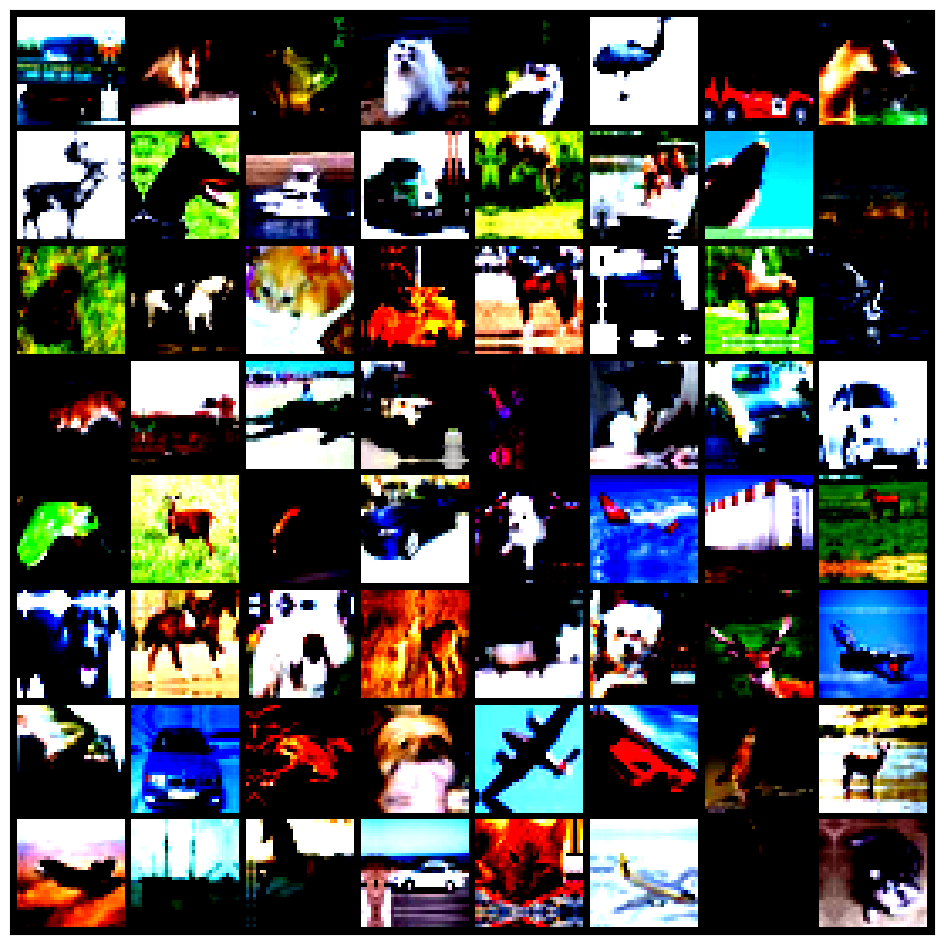

In [50]:
show_batch(train_dl)

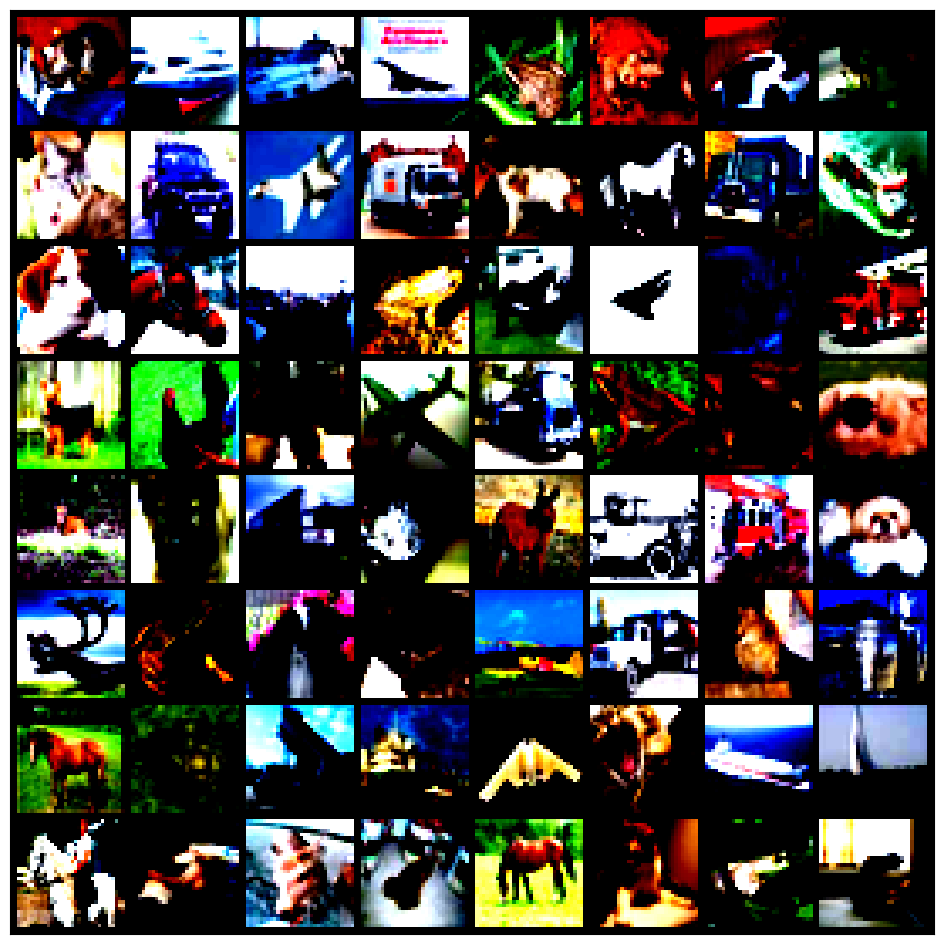

In [51]:
show_batch(valid_dl)

<a id="4"></a>
# GPU Helper Functions

To use a GPU, if one is available, we define a couple of helper functions (`get_default_device` & `to_device`) and a helper class `DeviceDataLoader` to move our model & data to the GPU as required.

In [52]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [53]:
device = get_default_device()
device

device(type='cuda')

We can now wrap our training and validation data loaders using `DeviceDataLoader` for automatically transferring batches of data to the GPU (if available).

In [54]:
train_dl= DeviceDataLoader(train_dl,device)
valid_dl = DeviceDataLoader(valid_dl, device)

We will use the ResNet9 architecture(https://www.myrtle.ai/2018/09/24/how_to_train_your_resnet/) :

![resnet-9](https://github.com/lambdal/cifar10-fast/raw/master/net.svg?sanitize=true)

![resnet-9](https://miro.medium.com/max/1140/1*D0F3UitQ2l5Q0Ak-tjEdJg.png)


In [55]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        _, preds = torch.max(out, dim=1)
        acc = accuracy(out, labels)  # Calculate accuracy
        return {'train_loss': loss, 'train_acc': acc}

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
      print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
        epoch, result['train_loss'], result['train_acc'], result['val_loss'], result['val_acc']))



<a id="5"></a>
# ResNet

In [56]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [57]:
model= to_device(ResNet9(3,10), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

<a id="6"></a>
## Training the model

Before we train the model, we're going to make a bunch of small but important improvements to our `fit` function:

* **Learning rate scheduling**: Instead of using a fixed learning rate, we will use a learning rate scheduler, which will change the learning rate after every batch of training. There are many strategies for varying the learning rate during training, and the one we'll use is called the **"One Cycle Learning Rate Policy"**, which involves starting with a low learning rate, gradually increasing it batch-by-batch to a high learning rate for about 30% of epochs, then gradually decreasing it to a very low value for the remaining epochs. Learn more: https://sgugger.github.io/the-1cycle-policy.html

* **Weight decay**: We also use weight decay, which is yet another regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function.Learn more: https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab

* **Gradient clipping**: Apart from the layer weights and outputs, it also helpful to limit the values of gradients to a small range to prevent undesirable changes in parameters due to large gradient values. This simple yet effective technique is called gradient clipping. Learn more: https://towardsdatascience.com/what-is-gradient-clipping-b8e815cdfb48


Let's define a `fit_one_cycle` function to incorporate these changes. We'll also record the learning rate used for each batch.

`Need to use NO_GRAD to keep the update out of the gradient computationIt boils down to the DYNAMIC GRAPH that PyTorch uses.
It allows us to perform regular Python operations on tensors, independent of PyTorch’s computation graph.``

In [58]:
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR, OneCycleLR
from torch.optim import SGD, Adam, RMSprop

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def fit(epochs, max_lr, model, train_loader, val_loader,
                  optimizer_name='SGD', weight_decay=0, grad_clip=None):

    torch.cuda.empty_cache()
    history = []


    # Select optimizer
    optimizers = {
        'SGD': SGD(model.parameters(), lr=max_lr, momentum=0.9, weight_decay=weight_decay),
        'Adam': Adam(model.parameters(), lr=max_lr, weight_decay=weight_decay),
        'RMSprop': RMSprop(model.parameters(), lr=max_lr, alpha=0.99, weight_decay=weight_decay)
    }
    optimizer = optimizers.get(optimizer_name)
    if optimizer is None:
        raise ValueError("Optimizer not recognized. Choose from ['SGD', 'Adam', 'RMSprop']")

    # Set up one-cycle learning rate scheduler
    sched = OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train() #Setting training mode
        train_losses = []
        train_accuracies = []
        lrs = []
        for batch in train_loader:
          output = model.training_step(batch)
          loss = output['train_loss']
          acc = output['train_acc']
          train_losses.append(loss)
          train_accuracies.append(acc)
          loss.backward()
          # Gradient clipping
          if grad_clip:
              nn.utils.clip_grad_value_(model.parameters(), grad_clip)

          optimizer.step()
          optimizer.zero_grad()

          # Record & update learning rate
          lrs.append(get_lr(optimizer))
          sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_accuracies).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


In [59]:
import torch.optim as optim

# Training with different optimizers
history_sgd = fit(20, 0.09, model, train_dl, valid_dl, optimizer_name='SGD')
history_adam = fit(20, 0.09, model, train_dl, valid_dl, optimizer_name='Adam')
history_rmsprop = fit(20, 0.09, model, train_dl, valid_dl, optimizer_name='RMSprop')


Epoch [0], train_loss: 1.8380, train_acc: 0.4112, val_loss: 1.4102, val_acc: 0.5312
Epoch [1], train_loss: 1.3663, train_acc: 0.5608, val_loss: 1.8031, val_acc: 0.5084
Epoch [2], train_loss: 1.2902, train_acc: 0.6118, val_loss: 1.0227, val_acc: 0.6652
Epoch [3], train_loss: 1.0295, train_acc: 0.6875, val_loss: 1.2408, val_acc: 0.6263
Epoch [4], train_loss: 0.7793, train_acc: 0.7538, val_loss: 1.0211, val_acc: 0.6984
Epoch [5], train_loss: 0.6811, train_acc: 0.7817, val_loss: 0.6548, val_acc: 0.7831
Epoch [6], train_loss: 0.5525, train_acc: 0.8170, val_loss: 0.5717, val_acc: 0.8157
Epoch [7], train_loss: 0.4739, train_acc: 0.8430, val_loss: 0.6324, val_acc: 0.8045
Epoch [8], train_loss: 0.4139, train_acc: 0.8607, val_loss: 0.5458, val_acc: 0.8263
Epoch [9], train_loss: 0.3609, train_acc: 0.8759, val_loss: 0.5141, val_acc: 0.8430
Epoch [10], train_loss: 0.3285, train_acc: 0.8873, val_loss: 0.5933, val_acc: 0.8225
Epoch [11], train_loss: 0.2970, train_acc: 0.8977, val_loss: 0.3805, val_ac

In [60]:
histories = {
    'SGD': history_sgd,
    'Adam': history_adam,
    'RMSprop': history_rmsprop
}

best_optimizer = None
best_accuracy = 0

for opt, history in histories.items():
    final_val_acc = history[-1]['val_acc']
    print(f"{opt} final validation accuracy: {final_val_acc:.4f}")
    if final_val_acc > best_accuracy:
        best_accuracy = final_val_acc
        best_optimizer = opt

print(f"The best optimizer is {best_optimizer} with a validation accuracy of {best_accuracy:.4f}.")


SGD final validation accuracy: 0.9118
Adam final validation accuracy: 0.9267
RMSprop final validation accuracy: 0.0998
The best optimizer is Adam with a validation accuracy of 0.9267.


In [70]:
def plot_accuracies(history_adam):
    accuracies = [x['val_acc'] for x in history]
    plt.figure(figsize=(10,6))
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

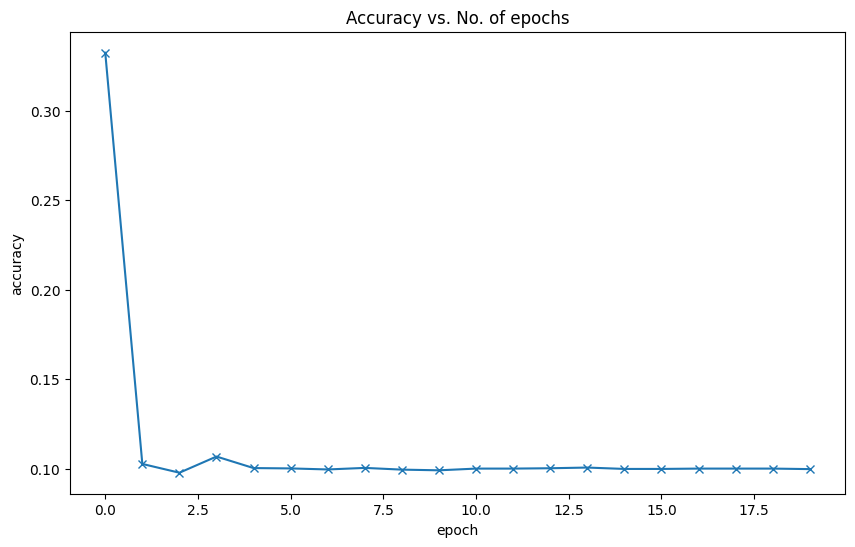

In [71]:

plot_accuracies(history_adam)

In [72]:
def plot_losses(history_adam):
    train_losses = [x.get('train_loss') for x in history_adam]
    val_losses = [x['val_loss'] for x in history_adam]
    plt.figure(figsize=(10,6))
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

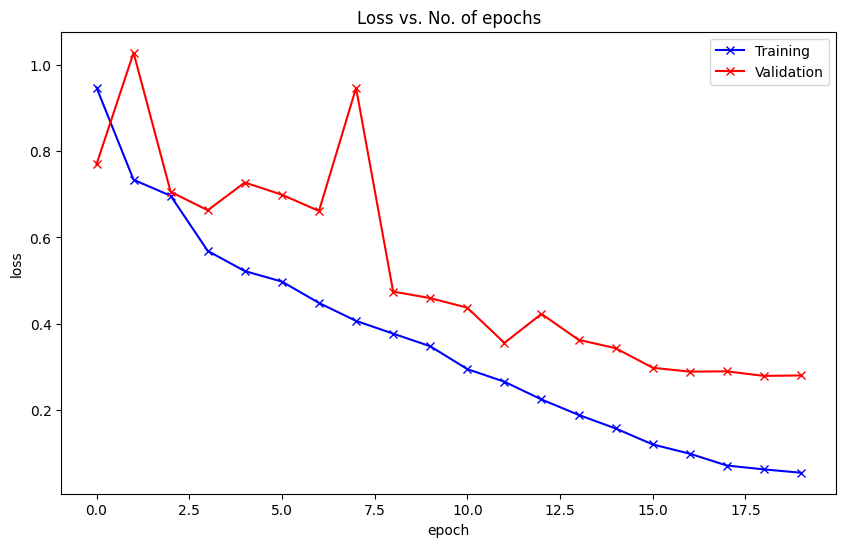

In [73]:
plot_losses(history_adam)

It's clear from the trend that our model isn't overfitting to the training data just yet. Finally, let's visualize how the learning rate changed over time, batch-by-batch over all the epochs.

In [74]:
def plot_lrs(history_adam):
    lrs = np.concatenate([x.get('lrs', []) for x in history_adam])
    plt.figure(figsize=(10,6))
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

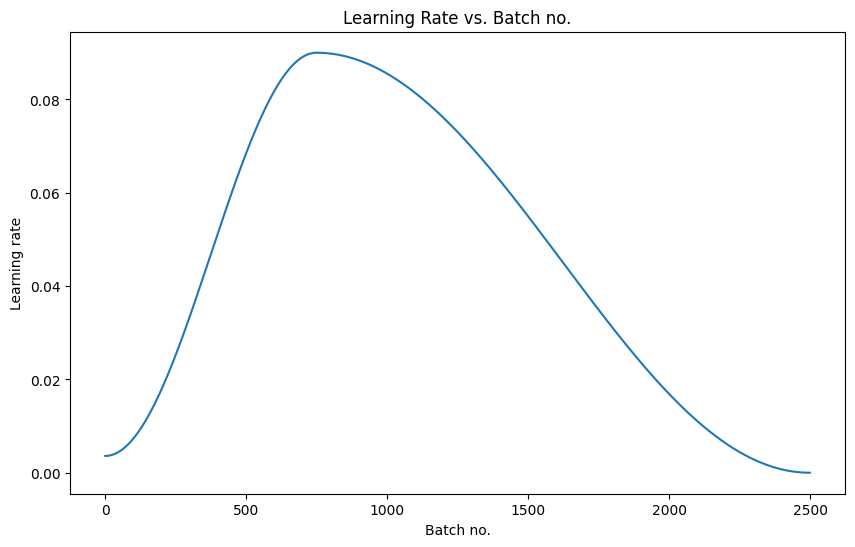

In [75]:
plot_lrs(history_adam)

`As expected, the learning rate starts at a low value, and gradually increases for 30% of the iterations to a
maximum value of `0.01`, and then gradually decreases to a very small value as per leslie smith.`

<a id="7"></a>
# Conclusion

<div class="list-group" id="list-tab" role="tablist">
<h1 class="list-group-item list-group-item-action active" data-toggle="list" style='background:black; border:0; color:#dfbf9f' role="tab" aria-controls="home"><center>Validation Accuracy ~ 94% </center></h1>


<div class="list-group" id="list-tab" role="tablist">
<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:black; border:0; color:#dfbf9f' role="tab" aria-controls="home"><center>If you found this notebook helpful , some upvotes would be very much appreciated - That will keep me motivated 😊</center></h2>


<div class="list-group" id="list-tab" role="tablist">
<h1 class="list-group-item list-group-item-action active" data-toggle="list" style='background:black; border:0; color:#ff6666' role="tab" aria-controls="home"><center>Thank You    🙏 </center></h1>
